In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from typing import List
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from indicators import Indicator
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [ ]:
# --- PCA Linear Model ---
def pca_linear_model(x: pd.DataFrame, y: pd.Series, n_components: int = 3):
    x_centered = x - x.mean()
    x_centered = x_centered.dropna()
    y = y.loc[x_centered.index]

    pca = PCA(n_components=n_components)
    x_pca = pca.fit_transform(x_centered)

    model = LinearRegression()
    model.fit(x_pca, y)

    preds = model.predict(x_pca)
    std_pred = np.std(preds)

    return model.coef_, pca.components_, x.mean(), std_pred


# --- PCA-RSI Strategy Signal Generator ---
def pca_rsi_model_rolling(
    ohlc: pd.DataFrame, rsi_lbs: List[int], train_size: int, step_size: int,
    n_components: int = 2, lookahead: int = 6, n_std: float = 1.5
):
    rsis = pd.DataFrame(index=ohlc.index)
    for lb in rsi_lbs:
        rsis[lb] = ta.rsi(ohlc['close'], lb)

    tar = np.log(ohlc['close']).diff(lookahead).shift(-lookahead)
    warm_up = max(rsi_lbs) * 2
    start_idx = warm_up + train_size

    model_pred = np.full(len(ohlc), np.nan)
    long_thresh = np.full(len(ohlc), np.nan)
    short_thresh = np.full(len(ohlc), np.nan)
    signal = np.zeros(len(ohlc))

    for i in range(start_idx, len(ohlc), step_size):
        train_data = rsis.iloc[i - train_size - lookahead: i - lookahead].copy()
        y_train = tar.iloc[i - train_size - lookahead: i - lookahead]

        coefs, evecs, rsi_means, std_pred = pca_linear_model(train_data, y_train, n_components)

        for j in range(i, min(i + step_size, len(ohlc))):
            curr_rsi = rsis.iloc[j] - rsi_means
            vec = np.array([np.dot(curr_rsi, evecs[k]) for k in range(n_components)])
            pred = np.dot(vec, coefs)

            model_pred[j] = pred
            l_thresh = n_std * std_pred 
            s_thresh = -n_std * std_pred
            long_thresh[j] = l_thresh
            short_thresh[j] = s_thresh

            if pred > l_thresh:
                signal[j] = 1
            elif pred < s_thresh:
                signal[j] = -1

    output_df = pd.DataFrame(index=ohlc.index)
    output_df['pred'] = model_pred
    output_df['long_thresh'] = long_thresh
    output_df['short_thresh'] = short_thresh
    output_df['signal'] = pd.Series(signal, index=ohlc.index).ffill().fillna(0)

    return output_df

In [ ]:
# --- Load Data ---
import joblib

tickers = ['BTCUSDT', 'ETHUSDT']
data_ = joblib.load('15m.joblib')
data_dict = {ticker: data_[ticker] for ticker in tickers}

In [ ]:
# --- Load Data ---
import joblib

tickers = ['BTCUSDT', 'ETHUSDT']
data_ = joblib.load('15m.joblib')
data_dict = {ticker: data_[ticker] for ticker in tickers}

# --- Strategy Parameters ---
fee_rate = .0005
slippage = .0005
fee_rate += slippage

train_size = 24 * 15
step_size = 24 * 15 // 2

bt_results = {}
for lookahead in range(5, 20, 1):
    results = []
    i = 0
    for data in data_dict.values():
        # --- Run PCA-RSI Strategy ---

        i += 1
        output = pca_rsi_model_rolling(
            data,
            rsi_lbs=list(range(2, 25)),
            train_size=train_size,
            step_size=step_size,
            n_components=3,
            lookahead=lookahead,
            n_std=2
        )

        # --- Merge Signals into Backtest DataFrame ---
        bt_data = data[['open', 'high', 'low', 'close', 'volume']].copy()
        bt_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        bt_data['signal'] = output['signal']
        bt_data = bt_data.dropna()



        class PrecomputedSignalStrategy(Strategy):
            def init(self):
                self.signal_series = self.data.df['signal']
                kelly_array = Indicator.kelly_criterion(self.data['Close'], 4 * 24 * 7, 4 * 24 * 2, 0.5)
                self.kelly_criterion = pd.Series(kelly_array, index=self.data.index)

            def next(self):
                i = self.data.index[-1]
                signal = self.signal_series.loc[i]
                kelly = self.kelly_criterion.loc[i]
                kelly = max(min(kelly, 1), 0.1)

                if signal == -1:
                    if not self.position.is_long:
                        self.position.close()
                        self.buy(size=kelly)

                elif signal == 1:
                    if self.position:
                        self.position.close()

        # --- Run Backtest ---
        bt = Backtest(
            bt_data,
            PrecomputedSignalStrategy,
            cash=10_000_000,
            commission=fee_rate
        )

        stats = bt.run()
        results.append(stats)

    bt_results[lookahead] = results

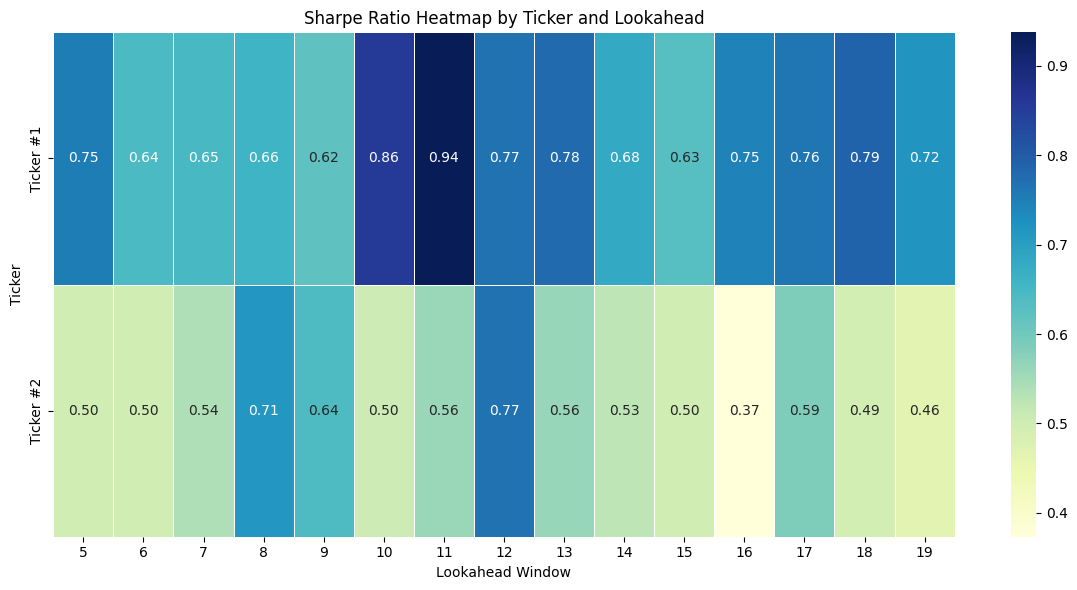

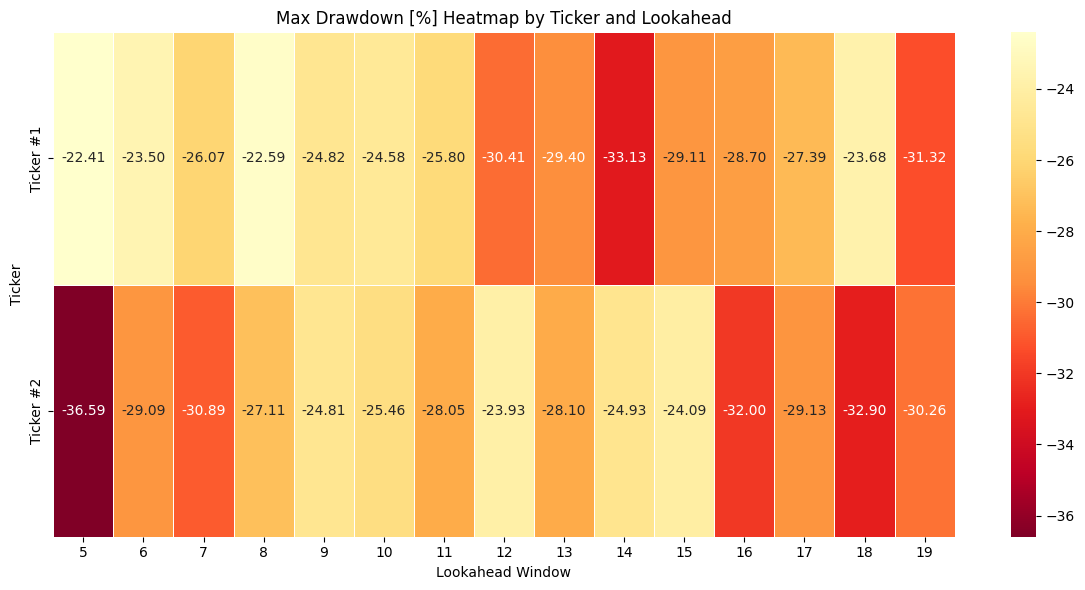

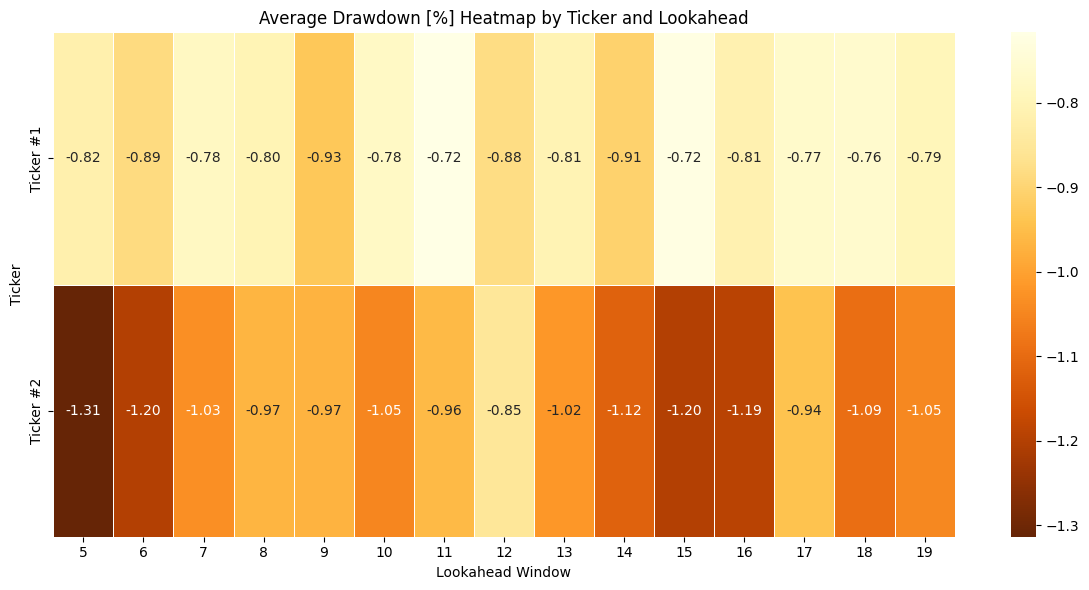

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Build Heatmap Data ---
sharpe_data = {}
avg_drawdown_data = {}
drawdown_data = {}

for lookahead, results in bt_results.items():
    for i, result in enumerate(results):
        if i not in sharpe_data:
            sharpe_data[i] = {}
            avg_drawdown_data[i] = {}
            drawdown_data[i] = {}
        sharpe_data[i][lookahead] = result['Sharpe Ratio']
        avg_drawdown_data[i][lookahead] = result['Avg. Drawdown [%]']
        drawdown_data[i][lookahead] = result['Max. Drawdown [%]']

# --- Convert to DataFrames ---
df_sharpe = pd.DataFrame.from_dict(sharpe_data, orient='index')
df_drawdown = pd.DataFrame.from_dict(drawdown_data, orient='index')
df_avg_drawdown = pd.DataFrame.from_dict(avg_drawdown_data, orient='index')

df_sharpe.index = [f"Ticker #{i+1}" for i in df_sharpe.index]
df_drawdown.index = [f"Ticker #{i+1}" for i in df_drawdown.index]
df_avg_drawdown.index = [f"Ticker #{i+1}" for i in df_avg_drawdown.index]

# Optional: ensure consistent column labels
df_sharpe.columns = df_sharpe.columns.astype(str)
df_drawdown.columns = df_drawdown.columns.astype(str)
df_avg_drawdown.columns = df_avg_drawdown.columns.astype(str)

# --- Plot Sharpe Heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(df_sharpe, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Sharpe Ratio Heatmap by Ticker and Lookahead")
plt.xlabel("Lookahead Window")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()

# --- Plot Max Drawdown Heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(df_drawdown, annot=True, fmt=".2f", cmap="YlOrRd_r", linewidths=0.5)
plt.title("Max Drawdown [%] Heatmap by Ticker and Lookahead")
plt.xlabel("Lookahead Window")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()

# --- Plot Avg Drawdown Heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(df_avg_drawdown, annot=True, fmt=".2f", cmap="YlOrBr_r", linewidths=0.5)
plt.title("Average Drawdown [%] Heatmap by Ticker and Lookahead")
plt.xlabel("Lookahead Window")
plt.ylabel("Ticker")
plt.tight_layout()
plt.show()

In [ ]:
# Choose optimize params to visulize
lookahead = 12
std_multiplier = 1.9

# --- Strategy Parameters ---
fee_rate = .0005
slippage = .0005
fee_rate += slippage

train_size = 24 * 15 * 2
step_size = 24 * 15 


for data in data_dict.values():
    # --- Run PCA-RSI Strategy ---

    output = pca_rsi_model_rolling(
        data,
        rsi_lbs=list(range(2, 25)),
        train_size=train_size,
        step_size=step_size,
        n_components=3,
        lookahead=lookahead,
        n_std=std_multiplier
    )

    # --- Merge Signals into Backtest DataFrame ---
    bt_data = data[['open', 'high', 'low', 'close', 'volume']].copy()
    bt_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    bt_data['signal'] = output['signal']
    bt_data = bt_data.dropna()


    class PrecomputedSignalStrategy(Strategy):
        def init(self):
            self.signal_series = self.data.df['signal']
            kelly_array = Indicator.kelly_criterion(self.data['Close'], 4 * 24 * 7, 4 * 24 * 2, 0.5)
            self.kelly_criterion = pd.Series(kelly_array, index=self.data.index)

        def next(self):
            i = self.data.index[-1]
            signal = self.signal_series.loc[i]
            kelly = self.kelly_criterion.loc[i]
            kelly = max(min(kelly, 1), 0.1)

            if signal == -1:
                if not self.position.is_long:
                    self.position.close()
                    self.buy(size=kelly)

            elif signal == 1:
                if self.position:
                    self.position.close()

    # --- Run Backtest ---
    bt = Backtest(
        bt_data,
        PrecomputedSignalStrategy,
        cash=10_000_000,
        commission=fee_rate
    )

    stats = bt.run()
    bt.plot()
    print(stats)

/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '8h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


Start                     2017-08-17 04:00...
End                       2025-07-22 03:30...
Duration                   2895 days 23:30:00
Exposure Time [%]                    49.95639
Equity Final [$]               20051099.23657
Equity Peak [$]                20414334.34613
Commissions [$]                 7120282.12183
Return [%]                          100.51099
Buy & Hold Return [%]              2645.79935
Return (Ann.) [%]                      9.1609
Volatility (Ann.) [%]                14.53298
CAGR [%]                              9.16428
Sharpe Ratio                          0.63035
Sortino Ratio                         1.01962
Calmar Ratio                          0.38635
Alpha [%]                          -201.66215
Beta                                  0.11421
Max. Drawdown [%]                    -23.7115
Avg. Drawdown [%]                    -0.77085
Max. Drawdown Duration     1082 days 10:00:00
Avg. Drawdown Duration        9 days 10:58:00
# Trades                          

/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '8h'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


Start                     2017-08-17 04:00...
End                       2025-07-22 03:30...
Duration                   2895 days 23:30:00
Exposure Time [%]                    49.46549
Equity Final [$]                 34531709.737
Equity Peak [$]                34796745.86619
Commissions [$]                   8406321.823
Return [%]                           245.3171
Buy & Hold Return [%]              1147.67785
Return (Ann.) [%]                    16.89916
Volatility (Ann.) [%]                19.60484
CAGR [%]                             16.90559
Sharpe Ratio                          0.86199
Sortino Ratio                         1.54673
Calmar Ratio                           0.5454
Alpha [%]                           109.82073
Beta                                  0.11806
Max. Drawdown [%]                   -30.98471
Avg. Drawdown [%]                    -0.86012
Max. Drawdown Duration      774 days 11:45:00
Avg. Drawdown Duration        5 days 11:47:00
# Trades                          